# Pipeline principal do projeto

### Importando as bibliotecas

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib

### Extração do dados

In [59]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")

train.head()

,id,title,text,subject,date,label
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0
3,15368,Biden asks U.S. Congress to allow unencumbered...,WASHINGTON (Reuters) - Vice President Joe Bide...,politicsNews,"September 8, 2016",0
4,6934,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,Donald Trump kicked off his Monday morning by ...,News,"February 6, 2017",1


In [60]:
test.head()

,id,title,text,subject,date
0,5398,Obama’s “CLOCK BOY” Comes Back To Texas…After ...,After 9 Months Of Hard-Core Islam Muslim Cloc...,politics,"Jun 27, 2016"
1,5503,LGBT VOLUNTEERS Aren’t Waiting To Be Thrown Of...,A group of volunteer soldiers announced this w...,politics,"Jul 25, 2017"
2,23151,Colombia authorizes air raids against dissiden...,BOGOTA (Reuters) - Colombia s armed forces hav...,worldnews,"October 31, 2017"
3,12669,"Timeline: Trump questions then honors ""one Chi...",(Reuters) - U.S. President Donald Trump agreed...,politicsNews,"February 10, 2017"
4,27864,Three policemen killed in Peru in drug-traffic...,LIMA (Reuters) - Three Peruvian policemen were...,worldnews,"September 7, 2017"


### Análise dos dados

Analisando a distribuição das classes

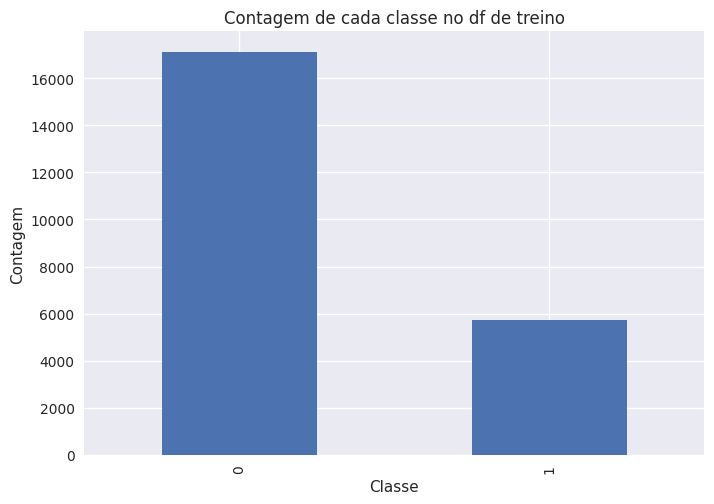

In [61]:
import matplotlib.pyplot as plt

train['label'].value_counts().plot(kind='bar')
plt.title('Contagem de cada classe no df de treino')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

In [62]:
train.isnull().sum()

id         0
title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [63]:
train.duplicated().sum()

np.int64(0)

#### Analisando o texto

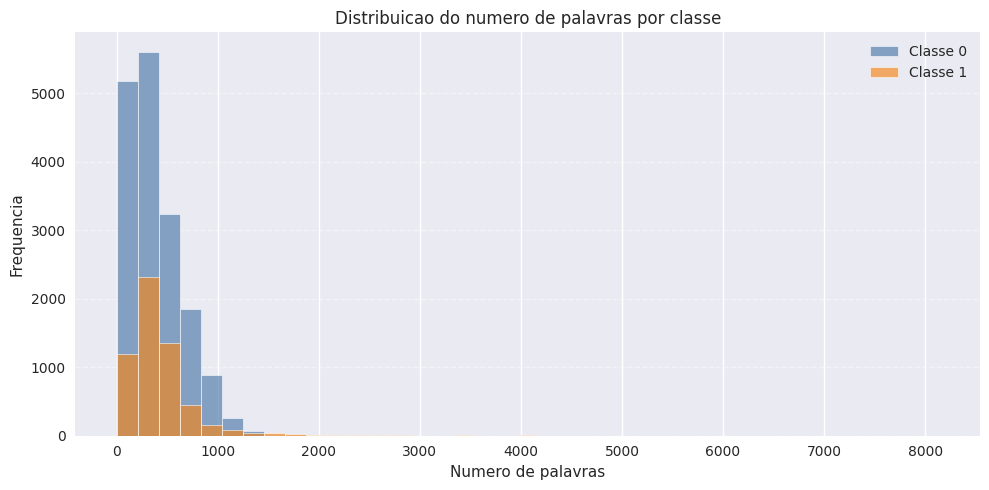

In [64]:
train_0 = train[train["label"] == 0].copy()
train_1 = train[train["label"] == 1].copy()

train_0["num_words"] = train_0["text"].apply(lambda x: len(x.split()))
train_1["num_words"] = train_1["text"].apply(lambda x: len(x.split()))

plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(10, 5))

all_counts = pd.concat([train_0["num_words"], train_1["num_words"]])
bins = np.linspace(all_counts.min(), all_counts.max(), 40)

ax.hist(
    train_0["num_words"],
    bins=bins,
    alpha=0.65,
    label="Classe 0",
    color="#4C78A8",
    edgecolor="white",
    linewidth=0.6,
)
ax.hist(
    train_1["num_words"],
    bins=bins,
    alpha=0.65,
    label="Classe 1",
    color="#F58518",
    edgecolor="white",
    linewidth=0.6,
)

ax.set_title("Distribuicao do numero de palavras por classe")
ax.set_xlabel("Numero de palavras")
ax.set_ylabel("Frequencia")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

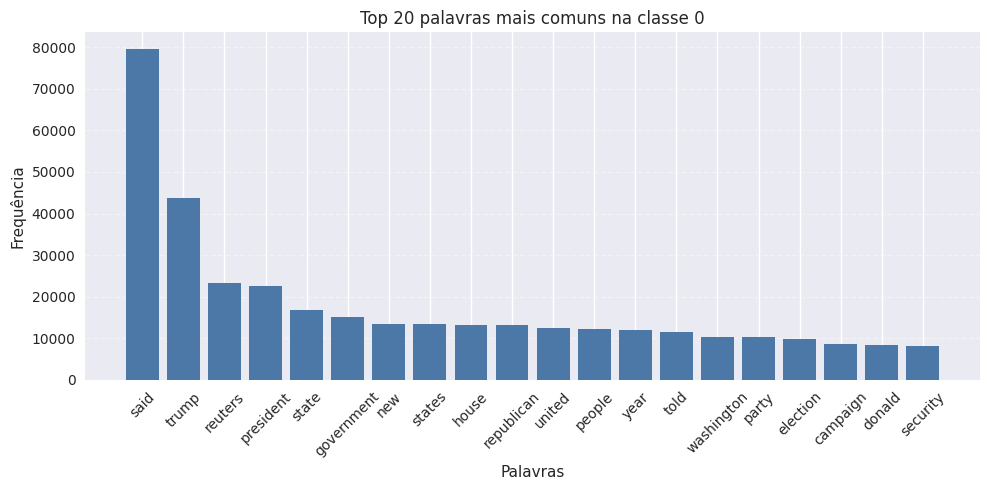

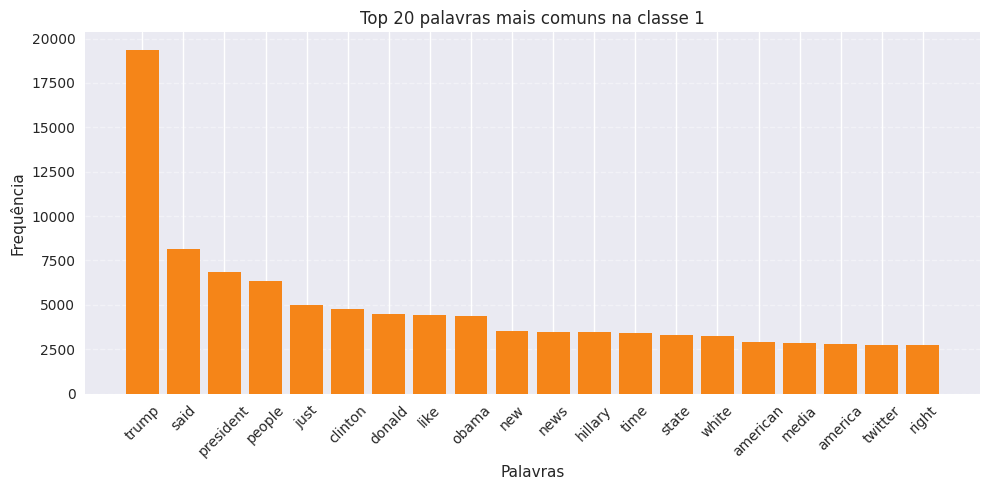

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

def plot_top_words(texts, label, n=20):
    vectorizer = CountVectorizer(stop_words="english")
    X = vectorizer.fit_transform(texts)
    word_counts = np.asarray(X.sum(axis=0)).flatten()
    vocab = vectorizer.get_feature_names_out()
    word_freq = dict(zip(vocab, word_counts))
    top_words = Counter(word_freq).most_common(n)
    words, counts = zip(*top_words)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color="#4C78A8" if label == 0 else "#F58518")
    plt.title(f"Top {n} palavras mais comuns na classe {label}")
    plt.xlabel("Palavras")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_top_words(train_0["text"], label=0)
plot_top_words(train_1["text"], label=1)

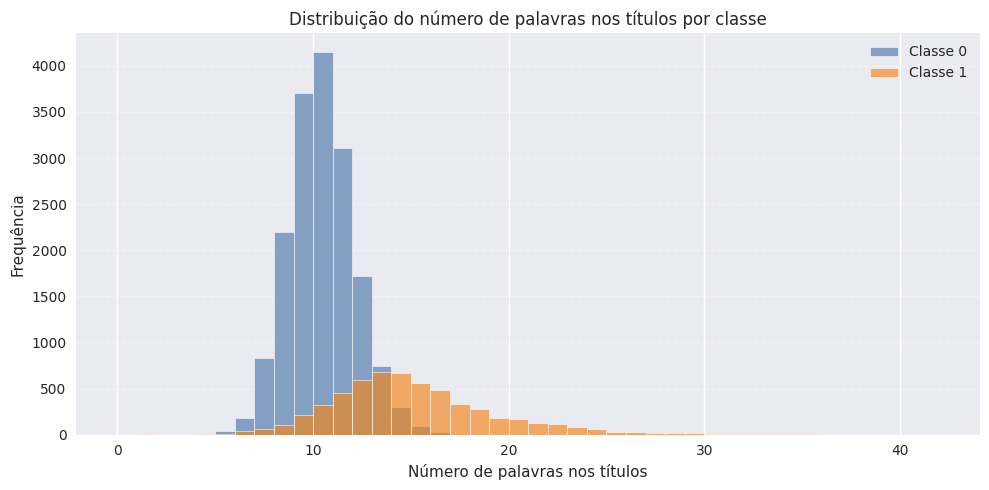

In [66]:
train_0["num_words_title"] = train_0["title"].apply(lambda x: len(x.split()))
train_1["num_words_title"] = train_1["title"].apply(lambda x: len(x.split()))

plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(10, 5))
all_counts_title = pd.concat([train_0["num_words_title"], train_1["num_words_title"]])
bins_title = np.arange(0, all_counts_title.max() + 1, 1)
ax.hist(
    train_0["num_words_title"],
    bins=bins_title,
    alpha=0.65,
    label="Classe 0",
    color="#4C78A8",
    edgecolor="white",
    linewidth=0.6,
)
ax.hist(
    train_1["num_words_title"],
    bins=bins_title,
    alpha=0.65,
    label="Classe 1",
    color="#F58518",
    edgecolor="white",
    linewidth=0.6,
)
ax.set_title("Distribuição do número de palavras nos títulos por classe")
ax.set_xlabel("Número de palavras nos títulos")
ax.set_ylabel("Frequência")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

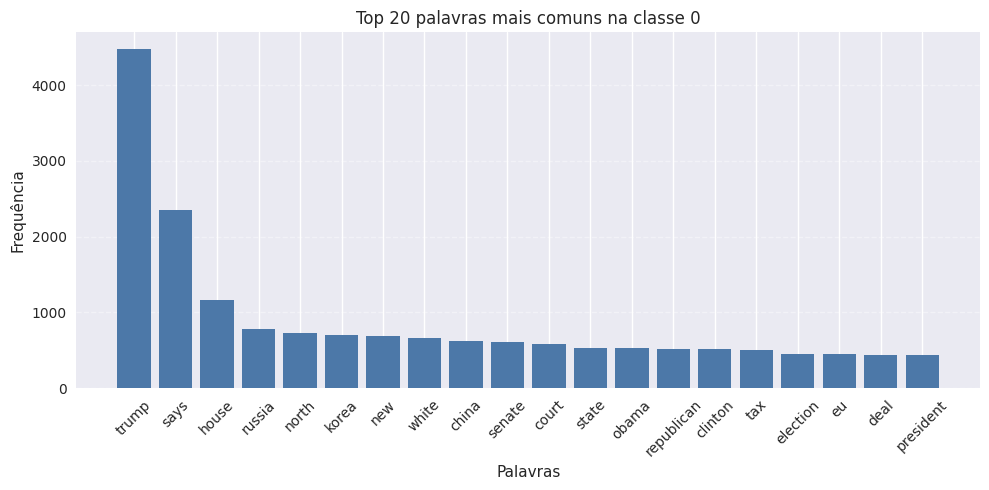

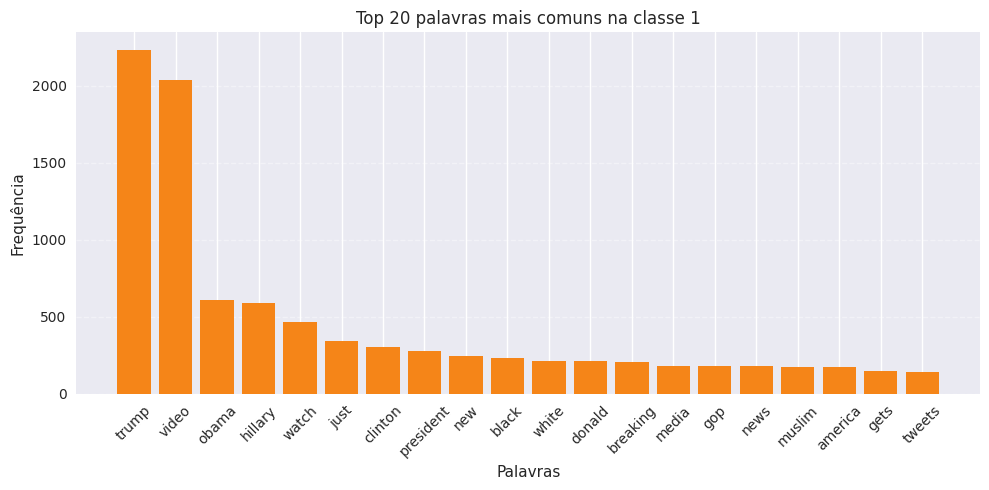

In [67]:
plot_top_words(train_0["title"], label=0)
plot_top_words(train_1["title"], label=1)

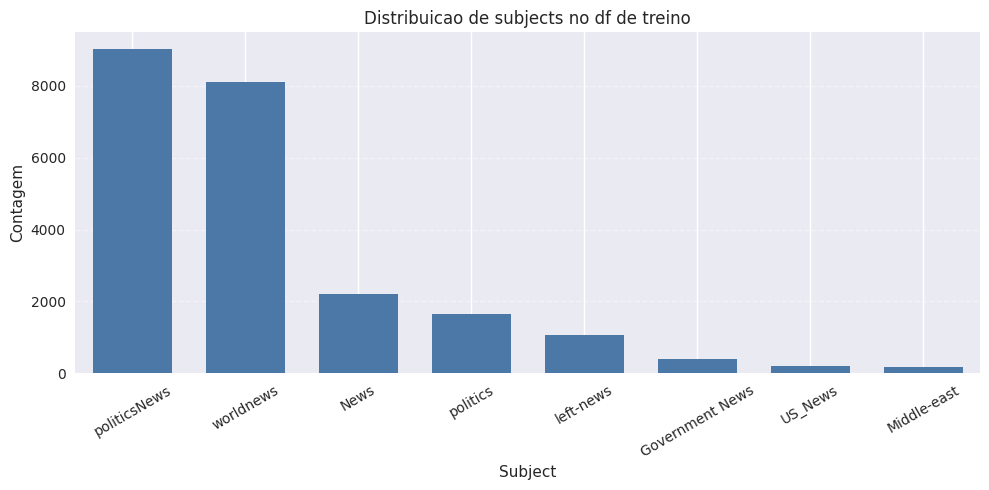

In [68]:
counts = train["subject"].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(counts.index, counts.values, color="#4C78A8", width=0.7)

ax.set_title("Distribuicao de subjects no df de treino")
ax.set_xlabel("Subject")
ax.set_ylabel("Contagem")
ax.grid(axis="y", linestyle="--", alpha=0.4)

ax.tick_params(axis="x", labelrotation=30)
ax.margins(x=0.02)

plt.tight_layout()
plt.show()

### Pré processamento

In [69]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train["clean_text"] = train["text"].apply(clean_text)
train["clean_title"] = train["title"].apply(clean_text)

[nltk_data] Downloading package punkt to /home/vlsm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/vlsm/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vlsm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
train.head()

,id,title,text,subject,date,label,clean_text,clean_title
0,13355,"Exclusive: Pentagon, Lockheed near deal on $9 ...",WASHINGTON (Reuters) - The U.S. Department of ...,politicsNews,"January 19, 2017",0,washington reuters us department defense lockh...,exclusive pentagon lockheed near deal billion ...
1,2113,“HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...,HILL larious! If this was a Donald Trump pi a...,left-news,"Aug 3, 2016",1,hill larious donald trump pi ata media would s...,“ hill ” arious…must see iowa parade goers tre...
2,27667,Philippine leader says 'no way' he'll do deal ...,MANILA (Reuters) - Philippine President Rodrig...,worldnews,"September 9, 2017",0,manila reuters philippine president rodrigo du...,philippine leader says way hell deal islamist ...
3,15368,Biden asks U.S. Congress to allow unencumbered...,WASHINGTON (Reuters) - Vice President Joe Bide...,politicsNews,"September 8, 2016",0,washington reuters vice president joe biden th...,biden asks us congress allow unencumbered zika...
4,6934,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,Donald Trump kicked off his Monday morning by ...,News,"February 6, 2017",1,donald trump kicked monday morning tweeting so...,trump claims ‘ negative polls ’ ‘ fake news ’ ...


### Vetorização

In [71]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    strip_accents="unicode"
)

X_train_set, X_test, y_train_set, y_test = train_test_split(
    train.drop(columns=["label"]),
    train["label"],
    test_size=0.1,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_set,
    y_train_set,
    test_size=0.2,
    random_state=42
)

X_train = vectorizer.fit_transform((X_train["clean_text"] + " " + X_train["clean_title"]).fillna(""))
X_val = vectorizer.transform((X_val["clean_text"] + " " + X_val["clean_title"]).fillna(""))
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

### Modelo

In [72]:
param_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000, solver="liblinear"),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'class_weight': [None, "balanced"],
        }
    },
    'Linear SVC': {
        'model': LinearSVC(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'loss': ["hinge", "squared_hinge"],
            'class_weight': [None, "balanced"],
        }
    },
    'SGD Classifier': {
        'model': SGDClassifier(random_state=42),
        'params': {
            'loss': ["hinge", "log_loss", "modified_huber"],
            'alpha': [1e-5, 1e-4, 1e-3],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'l1_ratio': [0.15, 0.5, 0.85],
            'class_weight': [None, "balanced"],
        }
    },
    'Multinomial NB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False],
        }
    }
}

print(f"Modelos configurados: {list(param_grid.keys())}\n")

# Executando o Grid Search para cada modelo
results = {}

for model_name, config in param_grid.items():
    print(f'Treinando {model_name}...')
    
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    results[model_name] = grid
    
    # Predições no validation set
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    print(f'  Best F1 Score (CV): {grid.best_score_:.4f}')
    print(f'  F1 Score (Validation): {f1:.4f}')
    print(f'  Melhores parâmetros: {grid.best_params_}')
    print()

# Resumo dos melhores modelos
print("\n" + "="*60)
print("RESUMO DOS MELHORES RESULTADOS")
print("="*60 + "\n")

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"{model_name}:")
    print(f"  F1 Score (Validation): {f1:.4f}")
    print(f"  Melhores parâmetros: {grid.best_params_}")
    print(f"  Relatório de classificação:")
    print(classification_report(y_val, y_pred))
    print()


Modelos configurados: ['Logistic Regression', 'Linear SVC', 'SGD Classifier', 'Multinomial NB']

Treinando Logistic Regression...
  Best F1 Score (CV): 0.9824
  F1 Score (Validation): 0.9871
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced'}

Treinando Linear SVC...


/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vlsm/miniconda3/envs/ligia-challenge-NLP/lib/python3.12/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

  Best F1 Score (CV): 0.9880
  F1 Score (Validation): 0.9899
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced', 'loss': 'squared_hinge'}

Treinando SGD Classifier...
  Best F1 Score (CV): 0.9917
  F1 Score (Validation): 0.9924
  Melhores parâmetros: {'alpha': 1e-05, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'loss': 'hinge', 'penalty': 'elasticnet'}

Treinando Multinomial NB...
  Best F1 Score (CV): 0.9424
  F1 Score (Validation): 0.9434
  Melhores parâmetros: {'alpha': 0.01, 'fit_prior': True}


RESUMO DOS MELHORES RESULTADOS

Logistic Regression:
  F1 Score (Validation): 0.9871
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced'}
  Relatório de classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3064
           1       0.99      0.98      0.99      1048

    accuracy                           0.99      4112
   macro avg       0.99      0.99      0.99      4112
weighted avg       0.99      0.99     

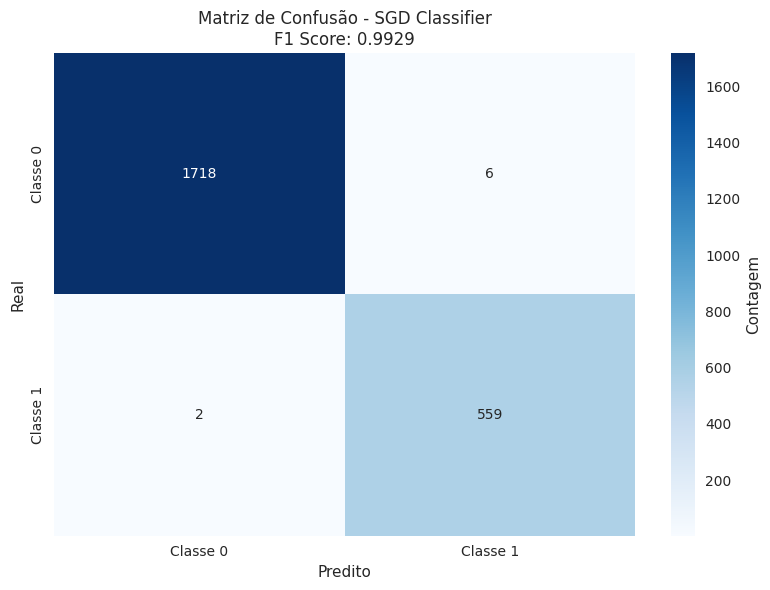


Melhor modelo: SGD Classifier
F1 Score: 0.9929

Matriz de Confusão:
[[1718    6]
 [   2  559]]


In [73]:
best_overall_model_name = None
best_overall_grid = None
best_overall_f1 = -1
X_test_transformed = vectorizer.transform(
    (X_test["clean_text"] + " " + X_test["clean_title"]).fillna("")
    )

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_test_transformed)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_overall_f1:
        best_overall_f1 = f1
        best_overall_grid = grid
        best_overall_model_name = model_name

# Gerar matriz de confusão
y_pred_best = best_overall_grid.best_estimator_.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'],
            cbar_kws={'label': 'Contagem'})
plt.title(f'Matriz de Confusão - {best_overall_model_name}\nF1 Score: {best_overall_f1:.4f}')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

print(f"\nMelhor modelo: {best_overall_model_name}")
print(f"F1 Score: {best_overall_f1:.4f}")
print(f"\nMatriz de Confusão:\n{cm}")


### Interpretabilidade

Interpretabilidade do melhor modelo linear: SGD Classifier
F1 Score: 0.9924



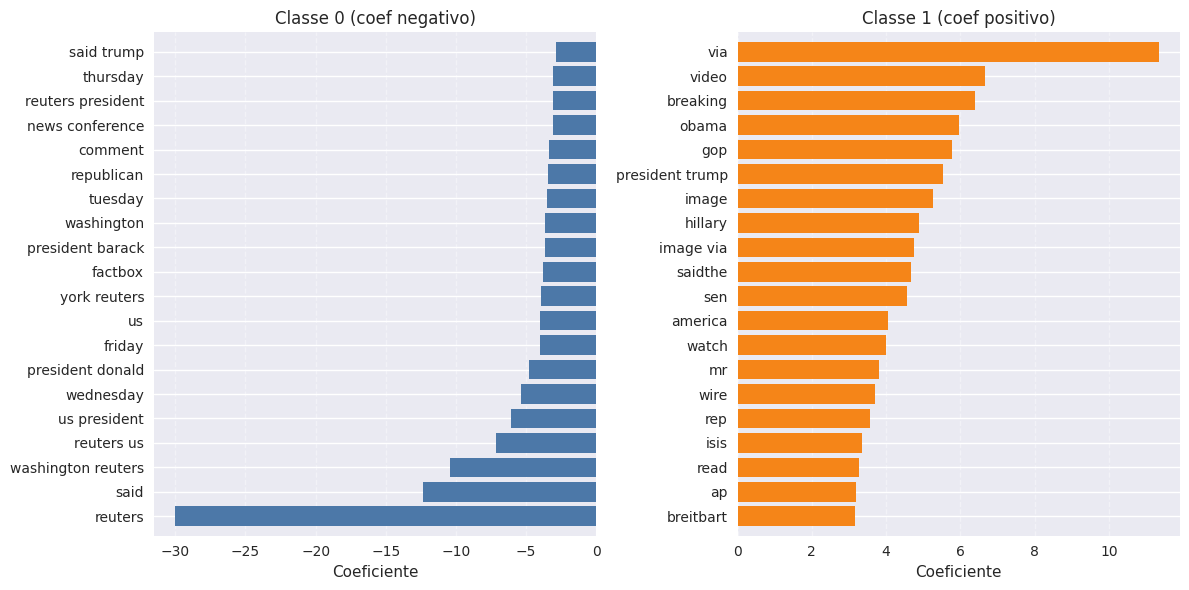

In [74]:
best_model_name = None
best_model = None
best_f1 = -1

for model_name, grid in results.items():
    # Apenas modelos lineares têm coef_
    if hasattr(grid.best_estimator_, 'coef_'):
        y_pred = grid.best_estimator_.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_model = grid.best_estimator_
            best_model_name = model_name

if best_model is not None:
    print(f"Interpretabilidade do melhor modelo linear: {best_model_name}")
    print(f"F1 Score: {best_f1:.4f}\n")
    
    feature_names = vectorizer.get_feature_names_out()
    coef = best_model.coef_[0]
    top_n = 20

    top_pos_idx = np.argsort(coef)[-top_n:]
    top_neg_idx = np.argsort(coef)[:top_n]

    top_pos = pd.Series(coef[top_pos_idx], index=feature_names[top_pos_idx]).sort_values()
    top_neg = pd.Series(coef[top_neg_idx], index=feature_names[top_neg_idx]).sort_values()

    plt.style.use("seaborn-v0_8")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].barh(top_neg.index, top_neg.values, color="#4C78A8")
    axes[0].set_title("Classe 0 (coef negativo)")
    axes[0].set_xlabel("Coeficiente")
    axes[0].grid(axis="x", linestyle="--", alpha=0.4)

    axes[1].barh(top_pos.index, top_pos.values, color="#F58518")
    axes[1].set_title("Classe 1 (coef positivo)")
    axes[1].set_xlabel("Coeficiente")
    axes[1].grid(axis="x", linestyle="--", alpha=0.4)

    for ax in axes:
        ax.margins(y=0.02)

    plt.tight_layout()
    plt.show()
else:
    print("Nenhum modelo linear encontrado para interpretabilidade.")


### Salvando o modelo

In [75]:
# Quero agora salvar o modelo com melhor F1 Score para uso futuro
joblib.dump(best_overall_grid.best_estimator_, '../models/best_model.joblib')

['../models/best_model.joblib']

### Fazendo a previsão para submissão no Kaggle

In [77]:
# Quero agora carregar o test para fazer submissão no Kaggle
test["clean_text"] = test["text"].apply(clean_text)
test["clean_title"] = test["title"].apply(clean_text)
X_test_final = vectorizer.transform(
    (test["clean_text"] + " " + test["clean_title"]).fillna("")
    )
y_test_final_pred = best_overall_grid.best_estimator_.predict(X_test_final)
submission = pd.DataFrame({
    'id': test['id'],
    'label': y_test_final_pred
})
submission.to_csv('../data/processed/submission.csv', index=False)